Investigating the deviations of GLV from MiCRM, and quantifying it using error functions. 


In [1]:
# from github temp.jl, converted to python

# this section is about incorporating temperature dependence 


import numpy as np
from numpy.random import default_rng
from scipy.stats import multivariate_normal

rng = default_rng(111) # random number generator 


# note that the u(T) and m(T) equation have the same structure, except the parameters are different. 
# both of the equations involve parameters like:
# B0 (base rate), E (activation energy), k (Boltzmann constant), Ed (deactivation energy), Tp (peak performance temperature), and Tr (reference temperature) 
# first, we want to generate random parameters for each consumer (as mentioned above), like B, E, Tp
# and for each of these temp-dependent parameters, we want to generate one for uptake u(T) and one for respiration m(T) 
# they're not actually fully random, as we do define mean and variance for teh parameters, and draw from a multivariate normal distribution 



def randtemp_param(N, kw):
    """
    Generate random temperature-dependent trait parameters for consumers.
    
    Returns:
        B: base rates (N x 2)
        E: activation energies (N x 2)
        Tp: peak temperatures (N x 2)
    """
    L = kw['L'] # leakage 
    rho_t = kw['rho_t']

    L_v = np.mean(L)
    B0_m = -1.4954 # I think this is mortality / respiration rate 
    B0_CUE = 0.1953 
    B0_u = np.log(np.exp(B0_m) / (1 - L_v - B0_CUE)) # I think this is uptake rate. dependent on carbon use efficiency (CUE) and leakage rate
    
    B0 = np.array([B0_u, B0_m]) # B0 is a vector of base rates for uptake and respiration
    B0_var = 0.17 * np.abs(B0) # variance of base rates, 0.17 is a scaling factor
    E_mean = np.array([0.8146, 0.5741]) # mean activation energies for uptake and respiration
    E_var = 0.1364 * E_mean # variance of activation energies, 0.1364 is a scaling factor
    cov_xy = rho_t * np.sqrt(B0_var * E_var) # covariance between base rates and activation energies, rho_t is the correlation coefficient

    cov_u = np.array([[B0_var[0], cov_xy[0]], [cov_xy[0], E_var[0]]]) # covariance matrix for uptake
    cov_m = np.array([[B0_var[1], cov_xy[1]], [cov_xy[1], E_var[1]]]) # covariance matrix for respiration

    allu = multivariate_normal.rvs(mean=[B0[0], E_mean[0]], cov=cov_u, size=N).T # draw random samples from multivariate normal distribution for uptake
    allm = multivariate_normal.rvs(mean=[B0[1], E_mean[1]], cov=cov_m, size=N).T # draw random samples from multivariate normal distribution for respiration

    B = np.column_stack((np.exp(allu[0]), np.exp(allm[0]))) # exponentiate the base rates to get the actual values
    E = np.column_stack((allu[1], allm[1])) # activation energies are already in the correct form

    Tpu = 273.15 + rng.normal(35, 5, N) # draw random peak temperatures for uptake from a normal distribution with mean 35 and std 5
    Tpm = Tpu + 3 # peak temperature for respiration is 3 degrees higher than for uptake
    Tp = np.column_stack((Tpu, Tpm)) # combine the peak temperatures into a single array 

    return B, E, Tp


# randtemp_param_test = randtemp_param(3, {'L': 0.4, 'rho_t': -0.75}) 
# print(randtemp_param_test) 
# this works - produces 2D arrays 


# now we have generated parameters (generating B, E, Tp) for each consumer 
# we did this by drawing from a multivariate normal distribution, with some constraints like mean, variance, correlation that we defined 
# now that the parameters are generated, we can incorporate them into the Arrhenius equation to calculate the temperature-dependent trait values 
# since uptake u(T) and respiration m(T) both depend on these parameters like B, E, Tp (which we have now defined) 




def temp_trait(N, kw):
    """
    Compute temperature-dependent trait scaling based on an Arrhenius-like thermal performance curve.
    
    Arguments:
        N: number of consumers
        kw: dict containing temperature parameters (T, Tr, Ed, L, rho_t)

    Returns:
        temp_p: temperature-scaled trait values (vector of size N)
        B, E: base rates and activation energies (N x 2)
        Tp: peak temperatures for uptake and respiration (N x 2)
    """
    k = 0.0000862  # Boltzmann constant. used in exponential term of the Arrhenius equation
    T = kw['T']
    Tr = kw['Tr'] 
    Ed = kw['Ed']

    B, E, Tp = randtemp_param(N, kw) # draw random base rates (B), activation energies (E), and peak temperatures (Tp) for each consumer. 
    # we are using the previously defined function to generate these parameters  

    # Arrhenius function with high-temp deactivation

    # uptake rate u(T)
    temp_p_u = B[:, 0] * np.exp((-E[:, 0] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 0] / (Ed - E[:, 0])) * np.exp(Ed / k * (1 / Tp[:, 0] - 1 / T)))
    
    # respiration rate m(T) 
    temp_p_m = B[:, 1] * np.exp((-E[:, 1] / k) * ((1 / T) - (1 / Tr))) / \
              (1 + (E[:, 1] / (Ed - E[:, 1])) * np.exp(Ed / k * (1 / Tp[:, 1] - 1 / T)))

    temp_p = np.column_stack((temp_p_u, temp_p_m))  # shape (N,2)
    
    return temp_p, B, E, Tp


# temp_trait_test = temp_trait(3, {'T': 273.15 + 10, 'Tr': 273.15 + 10, 'Ed': 3.5, 'L': 0.4, 'rho_t': -0.75})
# print(temp_trait_test)


# this temp_trait function uses the previous randtemp_param function to generate parameters for TPC, which are B, E, Tp 
# and then it uses these parameters to calculate the temperature-dependent trait values (u and m, which are uptake and respiration)  
# it does this by putting these parameters into the Arrhenius-like TPC equations u(T) and m(T) 
# the inputs are N (number of consumers) and kw (a dictionary of parameters like T, Tr, Ed, L, rho_t)
# and the outputs are the temp_p (temperature-scaled trait values), B (base rates), E (activation energies), and Tp (peak temperatures)
# we could define some temperature T, and the temp_p functions would calculate the resulting u and m for that temperature 
# so using this, we can compare e.g. low vs high temperatures by defining different T values 
# and potentially make continuous graphs of temperature vs growth rate or something, and use that to inform timescale separation / GLV accuracy 




In [2]:
# from github micrm_params.jl, converted to python 

# in the previous block of code, we generated temperature-dependent parameters
# but those parameters were just for the TPC 
# we also need to produce the other parameters for MiCRM 
# so this block of code focuses on defining parameters for MiCRM 
# and we later use these parameters to run simulations etc 


# kw is a dictionary carrying all the model inputs and intermediate results (temp, TPC scaling, leakage scalar, etc) 
# we like to include it (like in def_m) even though it's not needed for the default version
# so that any generator function can just pull out what it needs from kw 

import numpy as np

# Default parameter-generating functions
def def_m(N, M, kw):
    # Respiration (mortality) rates: ones vector of length N.
    return np.ones(N)

def def_rho(N, M, kw):
    # Resource-specific supply rates: ones vector of length M.
    # this was originally resource loss rate, but i changed it to supply so it makes sense with the equation 
    return np.ones(M)

def def_omega(N, M, kw):
    # Resource loss rates: ones vector of length M.
    return np.ones(M)


# the above code for def_m and def_rho are just returning vectors of ones, length N for respiration (m) and length M for supply (rho). 
# these are like the 'default' respiration/mortality rates, and default resource supply rates. def = default 
# depends on number of consumers N and number of resources M 
# later we can add temperature dependence, using functions we defined in previous section of code 



def def_u(N, M, kw):
    # Uptake matrix: each of N rows is drawn from a symmetric Dirichlet of dimension M.
    # this establishes the structure of the uptake function - it's a matrix of N x M 
    # unlike others like respiration (m) which is just a vector of length N 
    # numpy.random.dirichlet uses concentration parameters of length M
    return np.random.dirichlet(alpha=np.ones(M), size=N)


# the 'u' is an N x M matrix. each of the rows are sampled from a Dirichlet distribution. 
# each consumer is a row, and each resource is a column. 
# each consumer's uptake across resources (sum of a row) is 1. but this is randomly allocated among M resources. 
# so i guess the uptake is not absolute units but it's relative to other resources? 
# also i think this describes uptake preference (so how much of a certain resource it uptakes vs another one, relatively), not uptake rate which can be temp-dependent (as previously defined) 


def def_l(N, M, L):
    # Leakage-transformation tensor: shape (N, M, M). For each consumer i and resource alpha,
    # draw an M-vector from Dirichlet and scale by L[i].
    l = np.zeros((N, M, M))
    phi = np.ones(M)
    for i in range(N):
        for alpha in range(M):
            draw = np.random.dirichlet(alpha=phi)
            l[i, alpha, :] = draw * L[i]
    return l

# again, i think leakage is relative units (arbitrary units or sth)
# more about the 'preference' in terms of which resources are leaked 


# this is the N x M x M leakage tensor. for each consumer i and resource index alpha, we are drawing an M-vector from a Dirichlet distribution, and scaling it by L[i].
# this is the leakage matrix for each consumer-resource pair. 
# from the paper: 
# L encodes each strain's metabolic network. L is the leakage-transformation tensor. L determines how consumed substrates are leaked / metabolically transformed 
# so i think for each strain N + each resource M, there is a whole vector (length M) of what resources that this one coudl be leaked as or transformed into. 

# these previous functions are 'default' functions for generating parameters
# they create simple placeholder values like vectors of 1s, or random Dirichlet distributions 
# these functions can be overridden (e.g. after we add temp dependence)

# next, in generate_params, we will add temperature dependence to the parameters 

def generate_params(N,
                     M,
                     f_m=def_m,
                     f_rho=def_rho,
                     f_omega=def_omega,
                     f_u=def_u,
                     f_l=def_l,
                     **kwargs):
    
    # f_m = def_m means that if we don't provide a function for f_m, it will use the default one (def_m)
    # this is why we had to define the default functions earlier 
    # **kwargs is any other keyword arguments (not directly specified as function inputs here, but bundled together in dictionary)
    
    """
    Generate temperature-dependent MiCRM parameters.

    Parameters:
        N, M       : integers, number of consumers and resources
        f_m, f_rho, f_omega, f_u, f_l : functions to generate m, rho, omega, u, l
        kwargs     : other keyword arguments (e.g., T, rho_t, Tr, Ed, L)

    Returns:
        params : dict with keys 'N', 'M', 'u', 'm', 'l', 'rho', 'omega', 'lambda',
                 plus temperature traits and any extra kwargs
    """

    # Copy kwargs for internal use
    kw = dict(kwargs)

    # Temperature-dependent traits, as defined in previous code block 
    tt, B, E, Tp = temp_trait(N, kw) # according to previously defined temp_trait function 
    # tt is the first output of the temp_trait function, which is temp_p

    
    kw['tt'] = tt
   
    # in this section above:
    # we plug in N and kw (kw is a dictionary of parameters), both of which are inputs to the overall generate_params function
    # and using a previously defined function temp_trait, we get parameters for temperature dependence
    # the parameters generated include temp_p_u and temp_p_m 
    # now that we've generated temp_p_u and temp_p_m, we want to store them into kw dictionary 

    # Generate consumer parameters
    m = f_m(N, M, kw) # Respiration (mortality) rates
    u = f_u(N, M, kw) # Uptake matrix

    # this section above:
    # f_m and f_u generate the final parameters for uptake and mortality 
    # we haven't defined a custom function for f_m or f_u, so it will use the default ones we defined earlier
    # so here, it's basically same as m = def_m(N, M, kw) and u = def_u(N, M, kw)


    # Leakage-transformation tensor
    L = kw.get('L')         # Expect L in kwargs
    l = f_l(N, M, L)      # Leakage-transformation 

    # Total leakage per consumer-resource pair
    lambda_ = np.sum(l, axis=2)  # shape (N, M)

    # Resource parameters
    rho = f_rho(N, M, kw) 
    omega = f_omega(N, M, kw)

    # Assemble base parameter dict
    params = {
        'N': N,
        'M': M,
        'u': u,
        'm': m,
        'l': l,
        'rho': rho,
        'omega': omega,
        'lambda': lambda_,
        'L': L,
        'B': B,
        'E': E,
        'Tp': Tp,
        'tt': tt
    }
    # Merge in any extra user-supplied kwargs
    params.update(kwargs) 

    return params # so it shows the base parameter dictionary we defined within this function 





# test generate_params just to show how it works:
# given N, M, and other parameters like temperature, it generates parameters for MiCRM 
# and there is an element of stochasticity, because the community assemblies are random 

# params = generate_params(
#     N=10,
#     M=5,
#     T=310,
#     Tr=275,
#     Ed=2,
#     L=np.random.uniform(0.1, 0.5, size=N),
#     rho_t=1
# )

# print (params)






In [3]:
# from github dx_v2.jl, converted to python


# now that we've generated parameters, we can write the actual MiCRM model 




import numpy as np

def growth_MiCRM(dx, x, p, t, i):
    """
    Per-consumer growth contribution for the MiCRM system.
    
    dx : array of length N+M (mutated in-place)
    x  : current state vector [consumers (N), resources (M)]
    p  : parameter dict with keys 'm', 'u', 'l', 'N', 'M'
    t  : time (unused here)
    i  : index of the consumer species to update
    """
    # maintenance loss
    dx[i] = -x[i] * p['m'][i]  
    # uptake and leakage contributions
    for alpha in range(p['M']):
        resource_idx = p['N'] + alpha # index of the resource in the state vector, since dx is an array of length N+M
        uptake = x[resource_idx] * x[i] * p['u'][i, alpha]
        dx[i] += uptake
        # subtract leaked fraction
        for beta in range(p['M']):
            dx[i] -= x[i] * x[resource_idx] * p['u'][i, alpha] * p['l'][i, alpha, beta]



def supply_MiCRM(dx, x, p, t, alpha):
    """
    Supply (inflow minus outflow) for resource pools.
    
    dx : array of length N+M (mutated in-place)
    x  : current state vector
    p  : parameter dict with keys 'rho', 'omega', 'N', 'M'
    t  : time (unused)
    alpha : index of the resource pool to update
    """
    idx = p['N'] + alpha
    dx[idx] = p['rho'][alpha] - x[idx] * p['omega'][alpha]

    # slightly confusing - previously omega was labelled supply and rho the decay 
    # but was probably a typo 
    # have fixed previous code and included omega again
    # where rho is supply, and omega is decay 




def depletion_MiCRM(dx, x, p, t, alpha, i):
    """
    Resource depletion (uptake and leakage reintroduction) for MiCRM.
    
    dx : array of length N+M (mutated in-place)
    x  : current state vector
    p  : parameter dict
    t  : time (unused)
    alpha : resource index
    i     : consumer index
    """
    idx = p['N'] + alpha
    # uptake depletes resource
    dx[idx] -= x[idx] * p['u'][i, alpha] * x[i] # x[i] is for consumers, and x[idx] is for resources
    # leaked material from other resources
    for beta in range(p['M']):
        leak_idx = p['N'] + beta
        dx[idx] += x[leak_idx] * x[i] * p['u'][i, beta] * p['l'][i, beta, alpha]



# the MiCRM_dx and MiCRM_dxx functions are 2 versions of the full MiCRM 
# MiCRM_dx delegates each 'piece' of dynamics to 3 helper functions that we previously defined 
# this function here just computes derivatives. no callback.

def MiCRM_dx(x, t, p,
             growth=growth_MiCRM,
             supply=supply_MiCRM,
             depletion=depletion_MiCRM):
    """
    Full derivative for MiCRM: consumer + resource dynamics.
    
    Returns a new dx array (length N+M).
    """
    dx = np.zeros_like(x)
    # consumer dynamics
    for i in range(p['N']):
        if x[i] > 1e-5: # anything smaller than this is seen as extinct 
            growth(dx, x, p, t, i)
    # resource dynamics
    for alpha in range(p['M']):
        supply(dx, x, p, t, alpha)
        for i in range(p['N']):
            if x[i] > 1e-5:
                depletion(dx, x, p, t, alpha, i)
    return dx


# below, the MiCRM_dxx function does not use helper functions defined outside of this function like growth_MiCRM
# here, all the consumer and resource updates are directly written in one place, not split into helper functions 
# extinctions are not ignored here, it actually computes every term
# no callback again (same as MiCRM_dx). as in, it keeps going, no condition to stop integrating 



def MiCRM_dxx(x, t, p):
    """
    Combined MiCRM ODE right-hand side without callbacks.
    """
    dx = np.zeros_like(x)
    # consumers
    for i in range(p['N']):
        dx[i] = -p['m'][i] * x[i]
        for alpha in range(p['M']):
            res_idx = p['N'] + alpha
            dx[i] += x[i] * x[res_idx] * p['u'][i, alpha]
            for beta in range(p['M']):
                dx[i] -= x[i] * x[res_idx] * p['u'][i, alpha] * p['l'][i, alpha, beta]
    # resources
    for alpha in range(p['M']):
        idx = p['N'] + alpha
        dx[idx] = p['rho'][alpha] - x[idx] * p['omega'][alpha]
        for i in range(p['N']):
            dx[idx] -= p['u'][i, alpha] * x[idx] * x[i]
            for beta in range(p['M']):
                leak_idx = p['N'] + beta
                dx[idx] += x[leak_idx] * x[i] * p['u'][i, beta] * p['l'][i, beta, alpha]
    return dx






In [4]:
# FIGURE OUT HOW THE DERIVATION WORKS! 
# i think here it just defines the terms like 'r' and 'aij' 
# but for the report, should understand better how the derivation works 

# from github EFF_LV_p_opt.jl, converted to python

# this section defines parameters for effective GLV 

# notes from original jl file:
# Function for calculating effective Lotka-Volterra parameters.
# It is necessary to supply the parameters p and an ODE problem 
# solution containing equilibrium values for the system in question.


import numpy as np

def eff_LV_params(p, sol, verbose=False):
    """
    Calculate effective Lotka‐Volterra parameters from a MiCRM equilibrium.
    
    Parameters
    ----------
    p : dict
        Parameter dict with keys:
          - 'M','N'        : ints, number of resources and consumers
          - 'l'            : leakage tensor, shape (N, M, M)
          - 'rho','omega'  : resource supply and loss vectors, length M
          - 'm'            : mortality vector, length N
          - 'u'            : uptake matrix, shape (N, M)
          - 'lambda'       : total leakage, shape (N, M)
    sol : 2D array, shape (N+M, T_steps)
        ODE solution; columns are timepoints, last column is equilibrium.
    verbose : bool, default False
        If True, also return the resource‐derivative matrix dR and the A matrix.
    
    Returns
    -------
    result : dict
        Always contains:
          - 'alpha' : effective species interaction matrix (N×N)
          - 'r'     : effective intrinsic growth rates (length N)
          - 'N'     : number of consumers
        If verbose:
          - 'dR'    : ∂R/∂C matrix (M×N)
          - 'A'     : resource‐interaction matrix (M×M)
    """
    # Unpack
    M, N = p['M'], p['N']
    l = p['l']          # shape (N, M, M)
    rho = p['rho']      # length M
    omega = p['omega']  # length M
    m = p['m']          # length N
    u = p['u']          # shape (N, M)
    lam = p['lambda']   # shape (N, M)
    
    # Kronecker delta
    delta = lambda x, y: 1 if x == y else 0

    # Equilibrium values (last column of sol)
    Ceq = sol.y[:N, -1]          # consumer abundances at eq. -1 means the last column (last timestep)
    Req = sol.y[N:, -1]          # resource abundances at eq. -1 means the last column (last timestep)
    
    # modified from sol to sol.y 
    
    
    # i don't think we've supplied what 'sol' is yet. 
    # when we call the function, we need to define some 'sol' 
    # and then pass that into the function (the function will find parameters for ELV) 
    # e.g. sol would be the result of some MiCRM equation, and then we pass that into this function, and it finds Ceq and Req from that sol 
    # and then uses Ceq and Req, along with other steps and derivations below, to find parameters for ELV 



    # 1) Build the resource‐interaction matrix A (shape M×M)
    #    A_{αβ} = -ω_α + sum_i [ l[i,α,β]*u[i,β]*Ceq[i]  –  u[i,β]*Ceq[i]*δ(α,β) ]
    A = np.zeros((M, M))
    for α in range(M):
        for β in range(M):
            s = -omega[α]
            for i in range(N):
                s += l[i, α, β] * u[i, β] * Ceq[i]
                if α == β:
                    s -= u[i, β] * Ceq[i]
            A[α, β] = s

    # 2) Precompute inverse of A and the term u*(1–λ)
    invA = np.linalg.inv(A)
    A_thing = u * (1.0 - lam)   # shape (N, M)

    # 3) Partial derivatives ∂R_α/∂C_j at equilibrium (shape M×N)
    dR = np.zeros((M, N))
    for α in range(M):
        for j in range(N):
            s = 0.0
            for β in range(M):
                for γ in range(M):
                    s += invA[α, β] * u[j, β] * Req[γ] * (delta(β, γ) - l[j, β, γ])
            dR[α, j] = s

    # 4) Effective species‐species interaction matrix α_ij (shape N×N)
    alpha = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            alpha[i, j] = np.sum(A_thing[i, :] * dR[:, j])

    # 5) Components for intrinsic growth rates
    O = np.zeros(N)
    for i in range(N):
        O[i] = np.sum(A_thing[i, :] * Req)

    P = np.zeros(N)
    for i in range(N):
        P[i] = np.dot(alpha[i, :], Ceq)

    # 6) Effective growth rates r_i = O_i – P_i – m_i
    r_eff = O - P - m

    # 7) Assemble results
    result = {'alpha': alpha, 'r': r_eff, 'N': N}
    if verbose:
        result.update({'dR': dR, 'A': A})
    return result




In [5]:
# from github LV_dx.jl, converted to python

# now that we have the parameters for the effective GLV (parameters from previous section of code) we can define the Lotka-Volterra equations

import numpy as np

def growth_LV(dx, x, p, t, i):
    """
    Compute the per-species contribution to the derivative dx[i] 
    for species i in a Lotka-Volterra system.
    Mutates the dx array in place.
    
    Arguments:
      dx : 1D array (length N) of derivatives to update
      x  : 1D array (length N) of current abundances
      p  : dict of parameters, with keys:
           - 'r': intrinsic growth rates (array of length N)
           - 'alpha': interaction matrix (N x N array)
           - 'N': number of species
      t  : current time (unused here, but included for API consistency)
      i  : index of the species to update
    """
    dx[i] += p['r'][i] * x[i]
    for j in range(p['N']):
        dx[i] += x[i] * p['alpha'][i, j] * x[j]


# growth_LV computes rate of change of a single species i in the Lotka-Volterra system
# it adds the intrinsic growth term (r_i * x_i) 
# and then for each other species j, it adds the interaction term (alpha_ij * x_j)
# this describes 1 species' contribution 



def LV_dx(x, t, p, growth=growth_LV):
    """
    Compute the full derivative vector for the Lotka-Volterra system.
    
    Arguments:
      x      : 1D array of current abundances
      t      : current time
      p      : dict of parameters (same as above)
      growth : function to compute per-species updates (defaults to growth_LV)
    
    Returns:
      dx : 1D array of derivatives for all species
    """
    dx = np.zeros_like(x)
    for i in range(p['N']):
        # only apply growth if population is above machine precision
        if x[i] > np.spacing(x[i]):
            growth(dx, x, p, t, i)
    return dx

# dx is the actual rate of change of the system, which is a vector of length N
# contains a whole system of LV differential equations, one for each species
# this LV_dx function loops through all species i, and calls growth_LV for each one
# the derivative vector dx can be passed to an ODE solver to compute the dynamics of the whole multi-species system over time 




# example usage:
# params = {
#     'N': 3,
#     'r': np.array([0.1, 0.2, 0.15]),
#     'alpha': np.array([[-0.01, -0.02, 0.0],
#                        [0.01, -0.03, -0.01],
#                        [0.0,  0.01, -0.02]])
# }
# x0 = np.array([1.0, 0.5, 0.2])
# t = 0.0
# dx = LV_dx(x0, t, params)
# print(dx)
# results would be [0.08   0.0965 0.0302] 


In [6]:
# FIGURE OUT. also read michael's github stuff on jacobian / linearisation etc 

# from github Jacobian.jl, converted to python

# this computes the Jacobian matrix 
# useful for downstream analysis on stability against perturbations 


import numpy as np

def eff_LV_jac(p_lv, sol, threshold=1e-7):
    """
    Compute the Jacobian matrix of the effective GLV system
    at equilibrium, restricted to the “feasible” subset of species.

    Parameters
    ----------
    p_lv : dict
        Output from eff_LV_params, with keys:
          - 'alpha': full N×N interaction matrix
          - 'r'    : length-N intrinsic growth rates
          - 'N'    : total number of species
    sol : OdeResult or similar
        Solution object from solve_ivp on the MiCRM ODEs.
        Expects sol.y shape = (N+M, n_timepoints)
    threshold : float
        Minimum equilibrium biomass to consider a species “present.”

    Returns
    -------
    LV_Jac : 2D array, shape (n_feasible, n_feasible)
        The Jacobian ∂(dx)/∂x of the reduced Lotka–Volterra
        system at equilibrium, only for species with biomass > threshold.
    """
    # 1) Extract final biomasses for consumers
    N_full = p_lv['N']
    # sol.y: rows 0..N_full-1 are consumer abundances
    bm = sol.y[:N_full, -1]

    # 2) Identify "feasible" species (biomass above threshold)
    feasible = np.where(bm > threshold)[0]
    n = feasible.size

    # 3) Subset the GLV parameters to those species
    alpha_full = p_lv['alpha']
    # Interaction submatrix
    alpha = alpha_full[np.ix_(feasible, feasible)]
    # Equilibrium biomasses for feasible species
    C = bm[feasible]

    # 4) Build the Jacobian: J_{ij} = α_{ij} * C_i
    #      (since d x_i/dt = x_i (r_i + Σ_j α_{ij} x_j))
    #      → ∂(dx_i)/∂x_j = δ_{i,j}(r_i + Σ_k α_{ik}C_k) + α_{ij} C_i
    # For off-diagonals and simpler local stability, one often uses α_{ij} C_i.
    LV_Jac = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            LV_Jac[i, j] = alpha[i, j] * C[i]

    return LV_Jac



In [ ]:
# from github sim_frame.jl, converted to python. sim_frame.jl includes the previous 6 files.
 

import numpy as np
from numpy.random import default_rng
from scipy.stats import dirichlet
from numpy.linalg import norm
import math


rng = default_rng()

# ————————————————————————————————————————————————
# Custom MiCRM‐parameter‐generator functions (override defaults)
# ————————————————————————————————————————————————

def F_m(N, M, kw):
    """
    Temperature‐dependent mortality (maintenance) rates.
    If 'tt' is in kw (an Nx2 array of TPC scalings), use the 2nd column;
    otherwise fallback to a constant 0.2 for each species.
    """
    if 'tt' in kw:
        # kw['tt'] assumed shape (N,2)
        return kw['tt'][:, 1] # this is the respiration/mortality part of 'tt', defined before. used to be temp_p_m.
    else:
        return np.full(N, 0.2)

def F_rho(N, M, kw):
    """
    Resource supply rates: constant ones by default.
    """
    return np.ones(M)

# could introduce temperature-dependence in this if we want to look at temp-dependent resource supply 
# same with omega below, seeing how temp affects loss/dilution of resources in specific ecosystems 

def F_omega(N, M, kw):
    """
    Resource loss/dilution rates: zero by default.
    """
    return np.zeros(M)

def F_u(N, M, kw):
    """
    Temperature‐scaled uptake matrix.
      - Draws N Dirichlet(1,…,1) rows of length M (relative preference).
      - Scales each row i by kw['tt'][i,0] if present, else by 2.5.
    """
    # draw relative preferences
    diri = np.stack([rng.dirichlet(np.ones(M)) for _ in range(N)], axis=0)
    
    if 'tt' in kw:
        u_sum = kw['tt'][:, 0] # this is the uptake part of 'tt', defined before. used to be temp_p_u. 
    else:
        u_sum = np.full(N, 2.5)
    
    # scale each row by its TPC magnitude
    return diri * u_sum[:, None]

# ————————————————————————————————————————————————
# Simple distance/similarity metrics
# ————————————————————————————————————————————————

def cosine_similarity(A, B):
    """
    Cosine similarity between 1D vectors A and B.
    """
    return np.dot(A, B) / (norm(A) * norm(B))

def bray_curtis_dissimilarity(A, B):
    """
    Bray–Curtis dissimilarity: sum|A–B| / sum(A+B)
    """
    return np.sum(np.abs(A - B)) / np.sum(A + B)

def euclidean_distance(A, B):
    """
    Euclidean distance between 1D vectors A and B.
    """
    return np.linalg.norm(A - B)

# ————————————————————————————————————————————————
# AIC for fitted models
# ————————————————————————————————————————————————

def AIC(model, n):
    """
    Akaike Information Criterion.
      - model.residuals(): array of residuals
      - model.coef(): array of fitted parameters
      - n: number of data points
    """
    residuals = model.residuals()  # user‐provided method
    RSS = np.sum(residuals ** 2)
    k = len(model.coef())
    return n * math.log(RSS / n) + 2 * k



In [11]:
########################### FOR GRAPHING (62 MINI GRAPHS OF MICRM VS GLV) ###########################



# # test out different temperatures

# import numpy as np
# from numpy.random import default_rng
# from scipy.integrate import solve_ivp
# from numpy import linspace 
# import matplotlib.pyplot as plt
# from numpy.linalg import norm, eig


# # want to first generate parameters for a particular randomly-assembled community
# # and then simulate 31 different temperatures for this same community (both MiCRM and EGLV graphs for each temperature) 
# # compare how temperature affects the deviation between MiCRM and EGLV graphs
# # later can add in equation to quantitatively evaluate deviations, and print that for each temperature
# # could also make graph for temperature vs species richness (number of surviving consumers)


# rng = default_rng(111)

# N = 7
# M = 5
# L = np.full(N, 0.3) # leakage (this is not temp dependent, as per original MiCRM)

# t0, t1 = 0.0, 2.5e10 # from 0 to a large value
# tspan = (t0, t1) # time span for integration
# x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)]) # initial conditions for consumers and resources

# # Temperature‐dependence parameters
# num_temps = 31 # number of temperatures
# rho_t = np.array([0.0, 0.0])   # minimal trade‐off
# Tr = 273.15 + 10 # reference temperature (10 °C)
# Ed = 3.5 

# # ─────────────────────────────────────────────────────────────────────────────
# # 2) Define a “steady‐state” event for solve_ivp
# #    Stops when ‖dx/dt‖ ≤ machine epsilon
# # ─────────────────────────────────────────────────────────────────────────────
# def mi_crm_rhs(t, x, p):
#     return MiCRM_dxx(x, t, p) # MiCRM_dxx is the full RHS of the MiCRM ODE, defined before 

# def ss_event(t, x, p): # steady state event 
#     return norm(mi_crm_rhs(t, x, p)) - np.finfo(float).eps

# ss_event.terminal = True
# ss_event.direction = 0

# # stops integration when system reaches steady state (machine epsilon), so it doesn't run forever



# ####### TEST OUT DIFFERENT TEMPERATURES #######


# structural = generate_params(
#     N, M,
#     f_u=def_u,      # relative preferences only
#     f_m=def_m,      # placeholder
#     f_rho=def_rho,
#     f_omega=def_omega,
#     f_l=def_l,
#     # *no* T, Tr, Ed, rho_t here
#     L=L,
#     T=273.15,   # dummy (This satisfies temp_trait’s requirement that kw contain T, rho_t, Tr, Ed) 
#     # since we are using the default def_u and def_m here, they ignore kw, so any T will work 
#     # this whole thing will just provide relative preferences (u) and a constant m=1    
#     rho_t=rho_t,  # dummy
#     Tr=Tr,        # dummy
#     Ed=Ed         # dummy
# )

# # the 'structural' parameters are static and don't change with temperature
# # e.g. the def_u only generates relative preferences, not absolute ones
# # however the uptake rate (u) will change with temperature. the relative preferences won't. 
# # other things like rho and omega also don't change with temperature

# # Inspect parameter arrays
# print("Uptake matrix structure u:\n", structural['u']) # should be N x M sized matrix 
# print("Mortality vector structure m:\n", structural['m']) # should be a vector containing M elements 
# print("Leakage tensor l shape:", structural['l'].shape) # should be N x M x M array 




# temp_vals = linspace(273.15, 273.15 + 30, num_temps) # 31 temperatures from 0 to 30 degrees C

# results = [] # store results for each temperature. it is a list of dictionaries. each temp would produce its own dictionary. 

# for T in temp_vals:

#     # temp-dependent scalars

#     temp_p, B, E, Tp = temp_trait(N, {
#         'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L
#     })
#     temp_p_u = temp_p[:,0]
#     temp_p_m = temp_p[:,1]

#     # full parameter dictionary for this temp

#     pT = {
#         **structural,            # brings in u_pref, l, B, E, Tp, L, N, M, etc.
#         'u': structural['u'] * temp_p_u[:,None],  # absolute uptake rates. the preference matrix from structural['u'] is multiplied (scaled) by the temperature-dependent uptake rates
#         'm': temp_p_m,                            # mortality rates. the preference matrix from structural['m'] is multiplied (scaled) by the temperature-dependent mortality rates
#         'lambda': np.sum(structural['l'], axis=2),
#         'T': T
#     }   
    

#     # set up integration range

#     t_max_micrm = 3000
#     t_max_glv   = 3000

#     t_eval_micrm = np.linspace(0, t_max_micrm, 1000)
#     t_eval_glv   = np.linspace(0, t_max_glv,   1000)


#     # solve MiCRM at this temperature
    

#     sol = solve_ivp(
#         lambda t, y: MiCRM_dxx(y, t, pT),
#         t_span=tspan, y0=x0, method='BDF',
#         t_eval=t_eval_micrm           
#         )

    
#     # solve EGLV at this temperature
    
#     p_lv = eff_LV_params(pT, sol, verbose=False)

#     sol_lv = solve_ivp(
#         lambda t, y: LV_dx(y, t, p_lv),
#         t_span=(0, t1), y0=sol.y[:N, 0],
#         method='BDF',
#         t_eval=t_eval_glv          
#         )
    
#     ##### store other interesting summary info #####

#     # equilibrium values

#     bm_eq = sol.y[:N, -1] # equilibrium consumer biomass 
#     survivors = np.where(bm_eq > 1e-7)[0]   # indices of extant consumers. 1.0e-7 is a threshold for extinction
#     N_s = survivors.size # number of survivors (equilibrium community richness)

#     # leading eigenvalue

#     LV_jac = eff_LV_jac(p_lv, sol)
#     eigvals = eig(LV_jac)[0]
#     leading = eigvals[np.argmax(np.real(eigvals))] # eigenvalue with largest real part (dominant/leading eigenvalue)    

#     ##### store results as a dictionary ##### 

#     results.append(dict(T=T, sol=sol, sol_lv=sol_lv, N_s=N_s, leading=leading))



# # plot results as mini plots 
# # it should show mini plots for 31 temperatures, each having MiCRM and EGLV side by side 

# nT = num_temps
# cols = 2

# # can set different t_max for micrm / glv
# # e.g. glv might take longer to equilibrate 
# # this will help us visualise deviations in final equilibrium values (if that's what we're interested in)

# fig, axes = plt.subplots(nT, cols, figsize=(6, nT*1.5), sharex=True, sharey=True)

# for idx, run in enumerate(results):
#     T = run['T'] - 273.15

#     # --- MiCRM panel ---
#     sol = run['sol']
#     ts = sol.t
#     mask = ts <= t_max_micrm
#     ts, Y = ts[mask], sol.y[:, mask]
#     ax1 = axes[idx, 0]
#     for i in range(N):
#         ax1.plot(ts, Y[i], lw=1)
#     for j in range(M):
#         ax1.plot(ts, Y[N+j], '--', lw=1)
#     ax1.set_xlim(0, t_max_micrm)
#     if idx == 0:
#         ax1.set_title("MiCRM")
#     if idx < (nT - 1):
#         ax1.set_xticks([])

#     # --- GLV panel ---
#     sol_lv = run['sol_lv']
#     ts_lv = sol_lv.t
#     mask_lv = ts_lv <= t_max_glv
#     ts_lv, Y_lv = ts_lv[mask_lv], sol_lv.y[:, mask_lv]
#     ax2 = axes[idx, 1]
#     for i in range(N):
#         ax2.plot(ts_lv, Y_lv[i], lw=1)
#     ax2.set_xlim(0, t_max_glv)
#     if idx == 0:
#         ax2.set_title("GLV")
#     if idx < (nT - 1):
#         ax2.set_xticks([])

#     # label the left of each row
#     ax1.set_ylabel(f"{T:.0f}°C")

# # shared labels
# fig.supxlabel("Time")
# fig.supylabel("Abundance")
# plt.tight_layout()
# plt.show()





In [22]:
### define functions for abundance deviation between MiCRM and EGLV ###

# this is for each community simulation (N consumers), for each temperature
# to be incorporated into the later functions and loops (loop this function for each temp, then for each community simulation)


import numpy as np


def err_eq (C_LV_eq, C_MiCRM_eq, eps=1e-7):

    """

    Compute mean log-ratio error between GLV- and MiCRM-predicted equilibrium consumer abundances 

    
    C_LV_eq: array of equilibrium consumer abundances from GLV (length N) 
    C_MiCRM_eq: array of equilibrium consumer abundances from MiCRM (length N)
    eps: small pseudocount to avoid division by zero (default 1e-7)


    """

    # convert inputs into numpy arrays of floats, for faster computation later

    C_LV = np.asarray(C_LV_eq, dtype=float)
    C_Mi = np.asarray(C_MiCRM_eq, dtype=float)

    # number of consumers 

    N = C_LV.size # length of the array = number of equilibrium consumer values = number of consumers (N) 

    # avoid division by 0 by adding epsilon (pseudocount)
    
    C_LV_safe = np.where(C_LV <= 0, eps, C_LV) # when C_LV is 0 or a tiny negative number, yield eps, else yield C_LV 
    C_Mi_safe = np.where(C_Mi <= 0, eps, C_Mi) # when C_Mi is 0 or a tiny negative number, yield eps, else yield C_Mi

    # ignore species that are extinct in both models (so they don't mess up log ratio average)

    thresh  = 1e-6
    mask = (C_LV_safe > thresh) | (C_Mi_safe > thresh)
    if mask.sum() == 0:
        return np.nan  # extinct 

    # log ratio error for LV vs MiCRM 

    log_ratios = np.log(C_LV_safe[mask] / C_Mi_safe[mask]) # this will be done for each consumer in N. divides 2 arrays (of the same length) element-wise. 
    # only when mask is true (mask is a boolean array), it will calculate the log ratio. if mask is true, it means neither MiCRM / GLV predict extinction. 
    # this way, the log ratio is informative. if both predict it's extinct, then there's no point in calculating that ratio (technically no deviations) 

    equilibrium_error = np.mean(log_ratios) # mean log ratio error across all consumers

    return equilibrium_error # this is the mean log ratio error between GLV and MiCRM for this community simulation at this temperature




[6.523569201733115e-08, -2.7381796315485453e-07, -1.650638975681728e-05, 0.20186635554222296, -7.467894774922189e-09, -2.906669016445325e-07, 9.985363335863244e-09, 2.8634740499405498e-08, -6.00867869742429e-07, 1.7580012126225756e-07, -6.652385863618452e-08, 2.9565678154412568e-06, -8.004074435299829e-09, -9.858641223067758e-08, 1.4777156722331412e-08, -1.2099067476457907e-06, 5.7278869552779426e-08, 9.48288991221889e-08, 1.7992181789413498e-06, 2.7577553093288047e-08, 9.137516232865426e-09, 0.0001270293859358121, 1.6601533467483596e-09, 2.392982827682229e-08, 1.811092797758304e-07, 2.2997879839052722e-07, 2.0319562053766341e-07, 5.944970215617483e-07, 4.940819300503014e-08, 1.1563748415866308e-07, 9.211325166931532e-08]
Got 31 temperatures, error values.


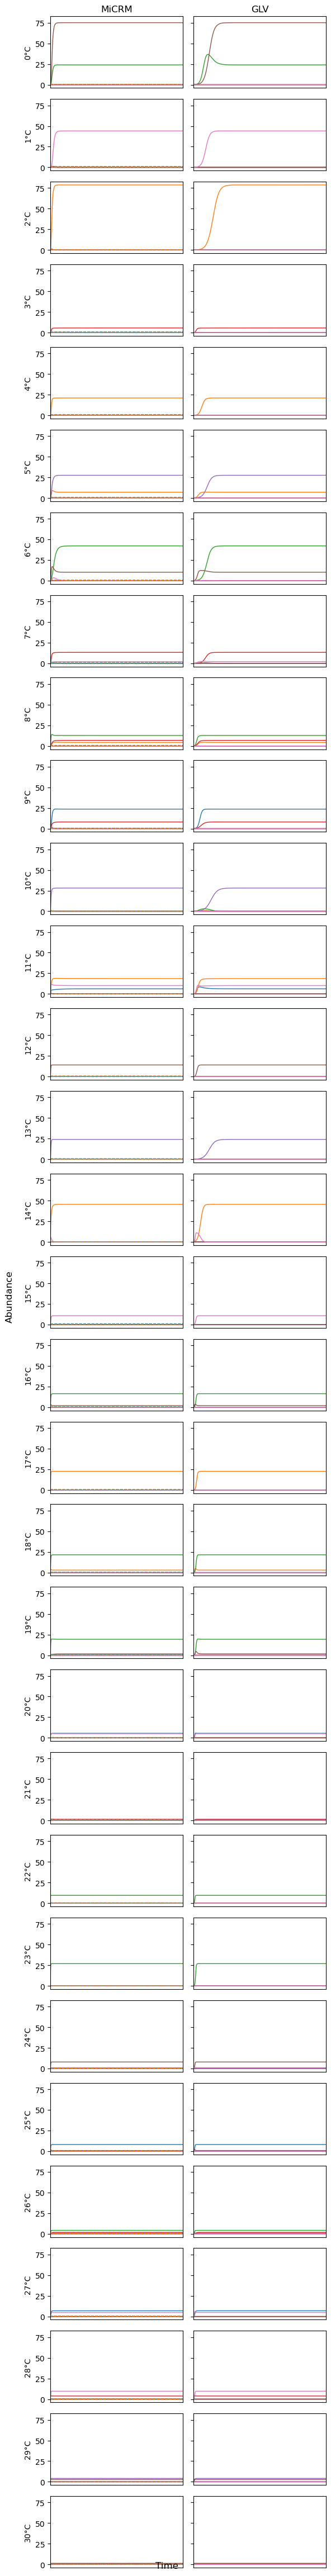

In [23]:
############################# NO GRAPHS - JUST ANALYSIS #############################

import numpy as np
from numpy.random import default_rng
from scipy.integrate import solve_ivp
from numpy import linspace 
import matplotlib.pyplot as plt
from numpy.linalg import norm, eig


# want to first generate parameters for a particular randomly-assembled community
# and then simulate 31 different temperatures for this same community (both MiCRM and EGLV graphs for each temperature) 
# compare how temperature affects the deviation between MiCRM and EGLV graphs
# later can add in equation to quantitatively evaluate deviations, and print that for each temperature
# could also make graph for temperature vs species richness (number of surviving consumers)


rng = default_rng(111)

N = 7
M = 5
L = np.full(N, 0.3) # leakage (this is not temp dependent, as per original MiCRM)

t0, t1 = 0.0, 2.5e10 # from 0 to a large value
tspan = (t0, t1) # time span for integration
x0 = np.concatenate([np.full(N, 0.1), np.full(M, 1)]) # initial conditions for consumers and resources

# Temperature‐dependence parameters
num_temps = 31 # number of temperatures
rho_t = np.array([0.0, 0.0])   # minimal trade‐off
Tr = 273.15 + 10 # reference temperature (10 °C)
Ed = 3.5 

# ─────────────────────────────────────────────────────────────────────────────
# 2) Define a “steady‐state” event for solve_ivp
#    Stops when ‖dx/dt‖ ≤ machine epsilon
# ─────────────────────────────────────────────────────────────────────────────
def mi_crm_rhs(t, x, p):
    return MiCRM_dxx(x, t, p) # MiCRM_dxx is the full RHS of the MiCRM ODE, defined before 

def ss_event(t, x, p): # steady state event 
    return norm(mi_crm_rhs(t, x, p)) - np.finfo(float).eps

ss_event.terminal = True
ss_event.direction = 0

# define steady-state event for GLV as well 

def ss_event_lv(t, x, p_lv):
    return norm(LV_dx(x, t, p_lv)) - np.finfo(float).eps
ss_event_lv.terminal = True
ss_event_lv.direction = 0

# stops integration when system reaches steady state (machine epsilon), so it doesn't run forever

####################
# actually, not sure if I'll be using this s.s. thing (the graph was having truncation issues, idk if it's related to this, so might cut this bit out and not call it. also that sign error.) 
####################



####### TEST OUT DIFFERENT TEMPERATURES #######


structural = generate_params(
    N, M,
    f_u=def_u,      # relative preferences only
    f_m=def_m,      # placeholder
    f_rho=def_rho,
    f_omega=def_omega,
    f_l=def_l,
    # *no* T, Tr, Ed, rho_t here
    L=L,
    T=273.15,   # dummy (This satisfies temp_trait’s requirement that kw contain T, rho_t, Tr, Ed) 
    # since we are using the default def_u and def_m here, they ignore kw, so any T will work 
    # this whole thing will just provide relative preferences (u) and a constant m=1    
    rho_t=rho_t,  # dummy
    Tr=Tr,        # dummy
    Ed=Ed         # dummy
)

# the 'structural' parameters are static and don't change with temperature
# e.g. the def_u only generates relative preferences, not absolute ones
# however the uptake rate (u) will change with temperature. the relative preferences won't. 
# other things like rho and omega also don't change with temperature

# Inspect parameter arrays
# print("Uptake matrix structure u:\n", structural['u']) # should be N x M sized matrix 
# print("Mortality vector structure m:\n", structural['m']) # should be a vector containing M elements 
# print("Leakage tensor l shape:", structural['l'].shape) # should be N x M x M array 




temp_vals = linspace(273.15, 273.15 + 30, num_temps) # 31 temperatures from 0 to 30 degrees C

results = [] # store results for each temperature. it is a list of dictionaries. each temp would produce its own dictionary. 

for T in temp_vals:

    # temp-dependent scalars

    temp_p, B, E, Tp = temp_trait(N, {
        'T': T, 'Tr': Tr, 'Ed': Ed, 'rho_t': rho_t, 'L': L
    })
    temp_p_u = temp_p[:,0]
    temp_p_m = temp_p[:,1]

    # full parameter dictionary for this temp

    pT = {
        **structural,            # brings in u_pref, l, B, E, Tp, L, N, M, etc.
        'u': structural['u'] * temp_p_u[:,None],  # absolute uptake rates. the preference matrix from structural['u'] is multiplied (scaled) by the temperature-dependent uptake rates
        'm': temp_p_m,                            # mortality rates. the preference matrix from structural['m'] is multiplied (scaled) by the temperature-dependent mortality rates
        'lambda': np.sum(structural['l'], axis=2),
        'T': T
    }   
    

    # set up integration range

    t_max_micrm = 5000
    t_max_glv   = 5000

    t_eval_micrm = np.linspace(0, t_max_micrm, 1000)
    t_eval_glv   = np.linspace(0, t_max_glv,   1000)


    # solve MiCRM at this temperature
    

    sol = solve_ivp(
        lambda t, y: MiCRM_dxx(y, t, pT),
        t_span=(0, t_max_micrm),
        y0=x0,
        method='BDF',
        t_eval=t_eval_micrm 
    )

    
    # solve EGLV at this temperature
    
    p_lv = eff_LV_params(pT, sol, verbose=False)

    sol_lv = solve_ivp(
        lambda t, y: LV_dx(y, t, p_lv),
        t_span=(0, t_max_glv), 
        y0=sol.y[:N, 0],
        method='BDF', 
        t_eval=t_eval_glv        
        )
    
    ##### equilibrium deviation calculations #####

    # first collect the equilibrium values for MiCRM and GLV (this is the last value in time series, t1)

    C_MiCRM_eq = sol.y[:N, -1] # equilibrium consumer biomass
    C_LV_eq = sol_lv.y[:N, -1] # equilibrium consumer biomass

    # then compute the mean log-ratio error between GLV- and MiCRM-predicted equilibrium consumer abundances

    """
    Need to check that there are no negative values for equilibrium, or the log ratio may not work 
    e.g. there might be tiny negative numbers due to slight undershoots

    check using the following code (put right before ErrEq) 

    print("MiCRM eq min/max:", C_MiCRM_eq.min(), C_MiCRM_eq.max())
    print("GLV  eq min/max:",    C_LV_eq.min(),    C_LV_eq.max())

    """
    
    ErrEq = err_eq(C_LV_eq, C_MiCRM_eq, eps=1e-7) 

    ##### store results as a dictionary ##### 

    results.append(dict(T=T, sol=sol, sol_lv=sol_lv, ErrEq=ErrEq))


# inspect to check that we have 31 error values (one for each temp)



errs = [entry['ErrEq'] for entry in results]
print(errs)
print("Got", len(errs), "temperatures, error values.")





# plot to check 

nT = num_temps
cols = 2

# can set different t_max for micrm / glv
# e.g. glv might take longer to equilibrate 
# this will help us visualise deviations in final equilibrium values (if that's what we're interested in)

fig, axes = plt.subplots(nT, cols, figsize=(6, nT*1.5), sharex=True, sharey=True)

for idx, run in enumerate(results):
    T = run['T'] - 273.15

    # --- MiCRM panel ---
    sol = run['sol']
    ts = sol.t
    mask = ts <= t_max_micrm
    ts, Y = ts[mask], sol.y[:, mask]
    ax1 = axes[idx, 0]
    for i in range(N):
        ax1.plot(ts, Y[i], lw=1)
    for j in range(M):
        ax1.plot(ts, Y[N+j], '--', lw=1)
    ax1.set_xlim(0, t_max_micrm)
    if idx == 0:
        ax1.set_title("MiCRM")
    if idx < (nT - 1):
        ax1.set_xticks([])

    # --- GLV panel ---
    sol_lv = run['sol_lv']
    ts_lv = sol_lv.t
    mask_lv = ts_lv <= t_max_glv
    ts_lv, Y_lv = ts_lv[mask_lv], sol_lv.y[:, mask_lv]
    ax2 = axes[idx, 1]
    for i in range(N):
        ax2.plot(ts_lv, Y_lv[i], lw=1)
    ax2.set_xlim(0, t_max_glv)
    if idx == 0:
        ax2.set_title("GLV")
    if idx < (nT - 1):
        ax2.set_xticks([])

    # label the left of each row
    ax1.set_ylabel(f"{T:.0f}°C")

# shared labels
fig.supxlabel("Time")
fig.supylabel("Abundance")
plt.tight_layout()
plt.show()


# analyse results for equilibrium abundance 




# note: removed diversity metric (# of surviving species) and leading eigenvalue for now
# this file focuses on abundance deviation calculations for GLV vs MiCRM 
# to add back diversity / eigenvalue, paste from temp_test and add back in results.append dictionary 

